# <b> Exploration of the Dumont & Gutkin model for 68 nodes network </b>
### <i> Marin Dauguet ~ 25 feb 2021 </i>
***


In [26]:
# Importing relevant stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-dark')

import os
import scipy
import h5py

from scipy.io import loadmat

from FCD_sp import getFCD

from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
import tvb.analyzers.fmri_balloon as bold
from tvb.simulator.plot import timeseries_interactive as timeseries_interactive

***
### <b> Setting it up </b>
First, we need to load in our empirical data.
***

In [2]:
# Importing FC and SC datasets
dataset0 = '/home/marindauguet/Documents/DATA_BERLIN/'
datasetFC = os.path.abspath(dataset0 + "/elife2018Schirner_dataset/")
datasetSC = os.path.abspath(dataset0 + "/RestingState_2011__2012_SC/")
annots = loadmat(datasetFC + '/empirical_fMRI.mat')

In [3]:
Nsubj = np.shape(annots['fMRI'])[1]
# Subject choice
subj = 11

In [4]:
fMRI = annots['fMRI'][:,subj][0][0]
TR = annots['TR'][0]

In [5]:
t = np.arange(fMRI.shape[0]) * TR
sub_id = annots['fMRI'][:,subj][0][1][0]
regions = np.hstack(annots['regions'][:,0])

In [6]:
SCannots = loadmat(datasetSC + '/' + sub_id + '_SC.mat')
weights = SCannots['SC_cap_agg_bwflav1']
tract_lengths = SCannots['SC_dist_mean_agg']

In [7]:
N = np.shape(regions)[0]
conn = connectivity.Connectivity(weights = weights, 
                                tract_lengths = tract_lengths,                                 
                                region_labels = regions, 
                                centres = np.ones([N]))
np.fill_diagonal(conn.weights, 0)
np.fill_diagonal(conn.tract_lengths, 0)

In [8]:
# Normalizing
conn.weights = conn.weights/np.max(conn.weights)
connSC = conn.weights

***
Now that we have our connectivity set, we can set up the simulation.
***

In [9]:
# Setting up integration time and simulation length
dt = 0.05
simlen = 1000 * 60

In [10]:
# Setting up the monitors
mon_tavg = monitors.TemporalAverage(period=5)
mon_bold = monitors.Bold(period=2000)
what_to_watch = (mon_tavg, mon_bold)

Coupling G and noise nsigma cannot exceed a certain value, otherwise causing an overflow error during simulation.

In [11]:
# Setting up the noise and the coupling
    # Noise
nsigma = .005
nsigma = (nsigma**2)/2
nsigma_dgmd = [0, nsigma, 0, 0, 0, 0, 0, 0]
hiss = noise.Additive(nsig=np.array(nsigma_dgmd))
heunint = integrators.HeunStochastic(dt = dt, noise = hiss)
    # Coupling
G = .05
con_coupling = coupling.Scaling(a = np.array(G))

In [12]:
# Setting up the model
dgmd = models.DumontGutkin(
    Delta_e=np.array([2.]),
    Delta_i=np.array([2.]),
    J_ee=np.array([2]),
    J_ei=np.array([15.]),
    J_ie=np.array([15.]),
    J_ii=np.array([0.]),
    I_i=np.array([0.]),
    I_e=np.array([8.875]),
    Gamma=np.array([5.]))

### <b> Simulation </b>
***

In [13]:
# Setting up the simulation
sim = simulator.Simulator(model = dgmd,
                          connectivity = conn,
                          conduction_speed = np.inf,
                          coupling = con_coupling,
                          integrator = heunint,
                          monitors = what_to_watch)
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 0e2967dd-d623-415d-babd-091587815808
coupling,Scaling gid: 5e688ea3-1860-4c92-8d46-e541d7d69642
gid,UUID('932a06a5-39b2-49cf-9661-cce4c2766ef5')
initial_conditions,None
integrator,HeunStochastic gid: 791d8fda-80d2-408f-a893-755d03c34866
model,DumontGutkin gid: c85c954f-6005-492a-972d-0109276b01c1
monitors,"(, )"
simulation_length,1000.0


In [14]:
# Simulation
    # Creating empty data lists
tavg_data, tavg_time = [], []
bold_data, bold_time = [], []
    # Simulation loop
for tavg, bold in sim(simulation_length = simlen):   
    if not tavg is None:
        tavg_time.append(tavg[0])                 
        tavg_data.append(tavg[1])
    if not bold is None:
        bold_time.append(bold[0])
        bold_data.append(bold[1])
    # Saving data
tavg_time = np.array(tavg_time)
tavg_data_all = np.array(tavg_data)
bold_time = np.array(bold_time)
bold_data_all = np.array(bold_data)

In [72]:
tavg_time.shape

(2000,)

In [98]:
bold.BalloonModel??

Init signature: bold.BalloonModel(**kwargs)
Docstring:     
Traited class [tvb.analyzers.fmri_balloon.BalloonModel]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



    A class for calculating the simulated BOLD signal given a TimeSeries
    object of TVB and returning another TimeSeries object.

    The haemodynamic model parameters based on constants for a 1.5 T scanner.

    

Attributes declared
"""""""""""""""""""

time_series : tvb.analyzers.fmri_balloon.BalloonModel.time_series = Attr(field_type=<class 'tvb.datatypes.time_series.TimeSeries'>, default=None, required=True)
    The timeseries that represents the input neural activity

dt : tvb.analyzers.fmri_balloon.BalloonModel.dt = Float(field_type=<class 'float'>, default=0.002, required=True)
    The integration time step size for the balloon model (s).
    If none is provided, by default, the TimeSeries sample period is used.

integrator : tvb.analyzers.fmri_balloon.BalloonModel.integrator = Attr(field_type=<class 't

In [104]:
#Create TimeSeries instance
tsr = TimeSeriesRegion(connectivity = conn,
                       data = tavg_data_all,
                       time = tavg_time,
                       sample_period = 2.)
tsr.configure()

#Create and run the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

bold_tsr = TimeSeriesRegion(connectivity = conn,
                            data = bold_data.data, 
                            time = bold_data.time)

In [17]:
    # Creating a Time Series instance
tsr = TimeSeriesRegion(connectivity = conn,
                       data = tavg_data_all[:,1:2,:,:],
                       time = tavg_time,
                       sample_period = 2.)
tsr.configure()

In [27]:
    # Creating and running the monitor/analyser
bold_model = bold.BalloonModel(time_series = tsr)
bold_data  = bold_model.evaluate()

bold_tsr = TimeSeriesRegion(connectivity = conn,
                            data = bold_data.data, 
                            time = bold_data.time)

/home/marindauguet/anaconda3/envs/py3/lib/python3.9/site-packages/tvb/analyzers/fmri_balloon.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return numpy.array([k1, k2, k3])


In [58]:
bold_data_all.shape

(30, 8, 68, 1)

In [45]:
databoldt = scipy.signal.resample(bold_data.data, 30)
timeboldt = scipy.signal.resample(bold_data.time, 30)

bold_data_u = databoldt[:, 0, :, 0]
for r in range(nrows):
    bold_data_u[:,r] -= np.min(bold_data_u[:, r])
bold_data_u /= np.max(bold_data_u)

tavg_data_n = tavg_data_all[:, 1, :, 0]
for r in range(nrows):
    tavg_data_n[:,r] -= np.min(tavg_data_n[:, r])
tavg_data_n /= np.max(tavg_data_n)

bold_data_n = bold_data_all[:, 1, :, 0]
for r in range(nrows):
    bold_data_n[:,r] -= np.min(bold_data_n[:, r])
bold_data_n /= np.max(bold_data_n)

In [59]:
bold_data_n.shape

(30, 68)

In [60]:
bold_data_u.shape

(30, 68)

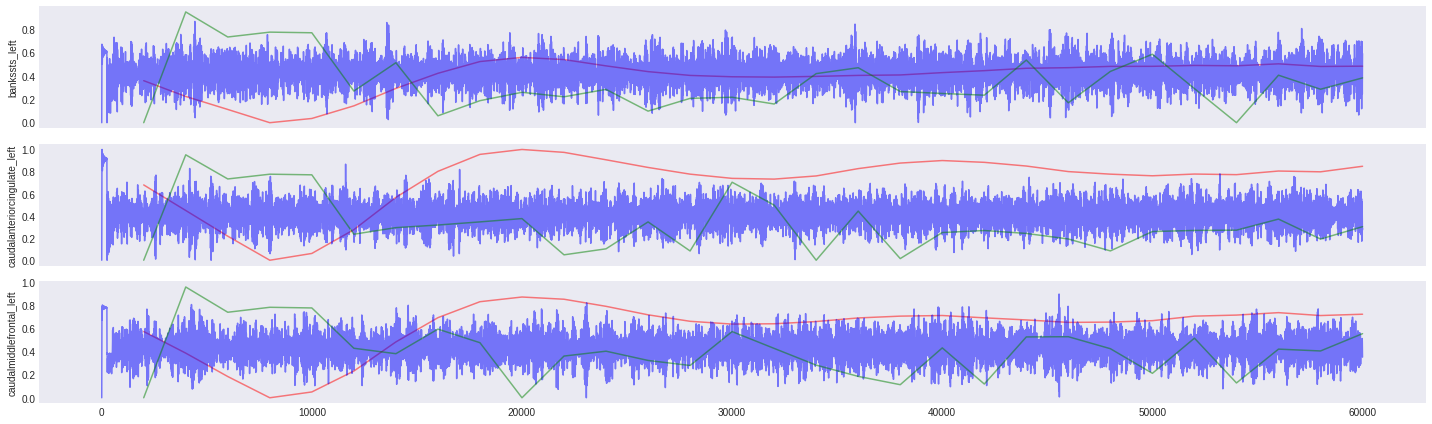

In [42]:
nrows = 3
fig, axs = plt.subplots(nrows=nrows, sharex=True, figsize=(20,nrows*2))

for i, reg in enumerate(sim.connectivity.region_labels[:3]):
    ax = axs[i]
    ax.plot(bold_time, bold_data_u[:, i], alpha=0.5, color='red')
    ax.plot(tavg_time, tavg_data_n[:, i], alpha=0.5, color='blue')
    ax.plot(bold_time, bold_data_n[:, i], alpha=0.5, color='green')
    ax.set(ylabel=reg)
fig.tight_layout()
plt.show()

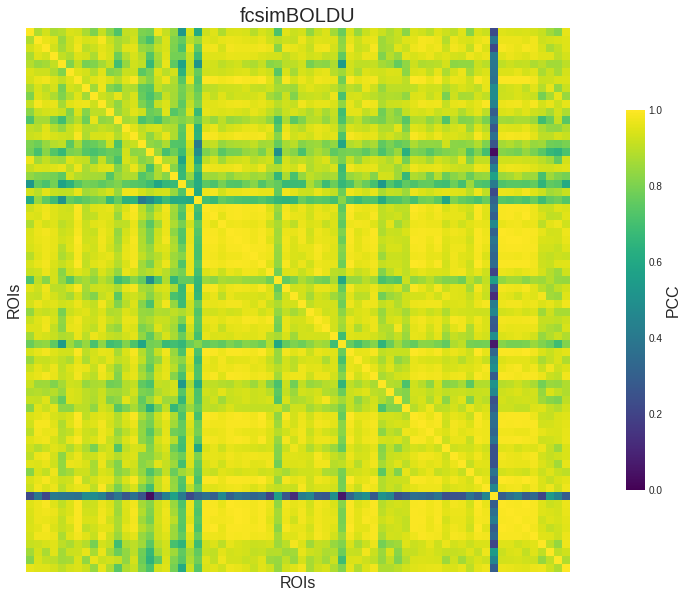

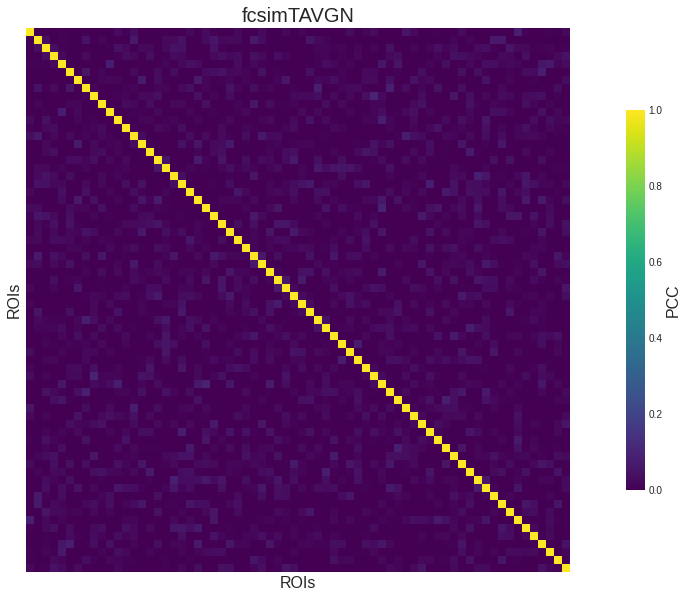

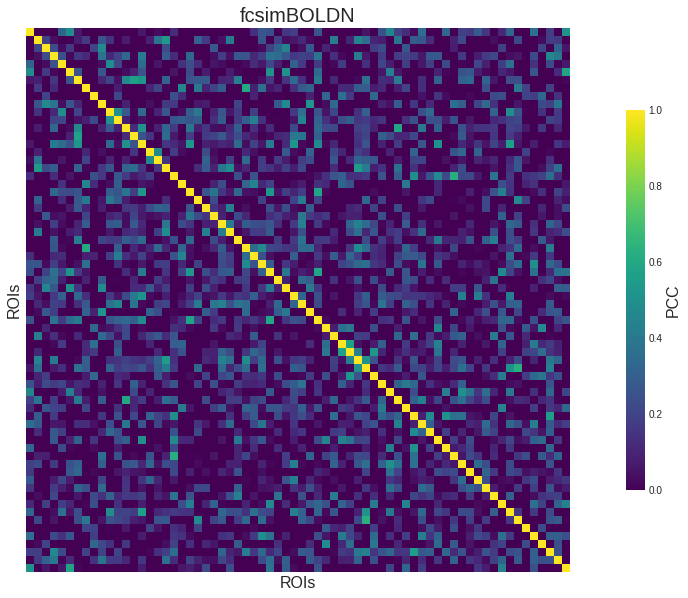

In [55]:
fcsimBOLDU = np.corrcoef(bold_data_u[5:,:].T)
fcsimTAVGN = np.corrcoef(tavg_data_n[100:,:].T)
fcsimBOLDN = np.corrcoef(bold_data_n[5:,:].T)

plt.figure(figsize=(20,10))
plt.imshow(fcsimBOLDU,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('fcsimBOLDU', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(fcsimTAVGN,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('fcsimTAVGN', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(fcsimBOLDN,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('fcsimBOLDN', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)
plt.show()

ValueError: The number of FixedLocator locations (67), usually from a call to set_ticks, does not match the number of ticklabels (68).

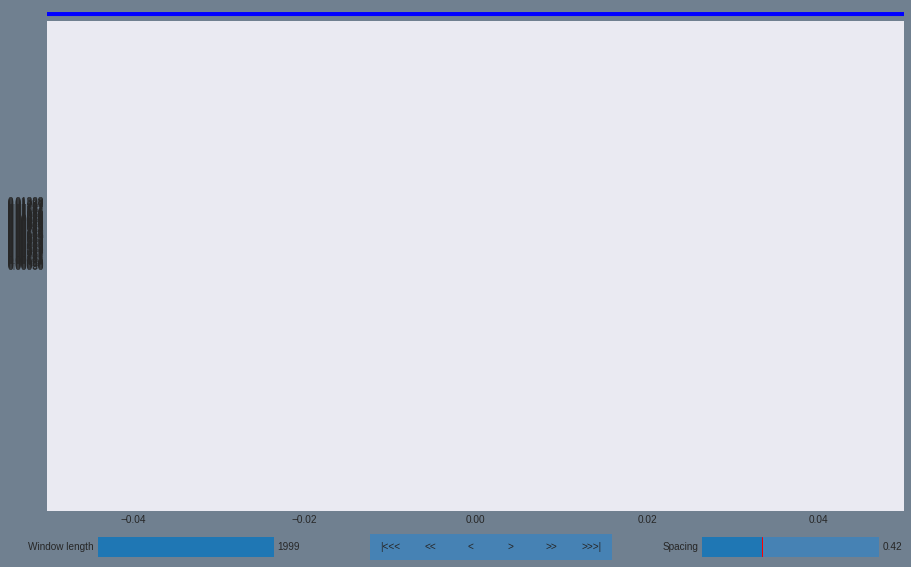

In [119]:
tsi = timeseries_interactive.TimeSeriesInteractive(time_series = bold_tsr)
tsi.configure()
tsi.show()

In [16]:
for index, item in enumerate(tavg_data_all):
    if np.isnan(item.all()) == False:
        print(index)
        break

0


***
### <b> Visualization </b>

Let's visualize TAVG signals.
***

Text(0.5, 1.0, 'V_e')

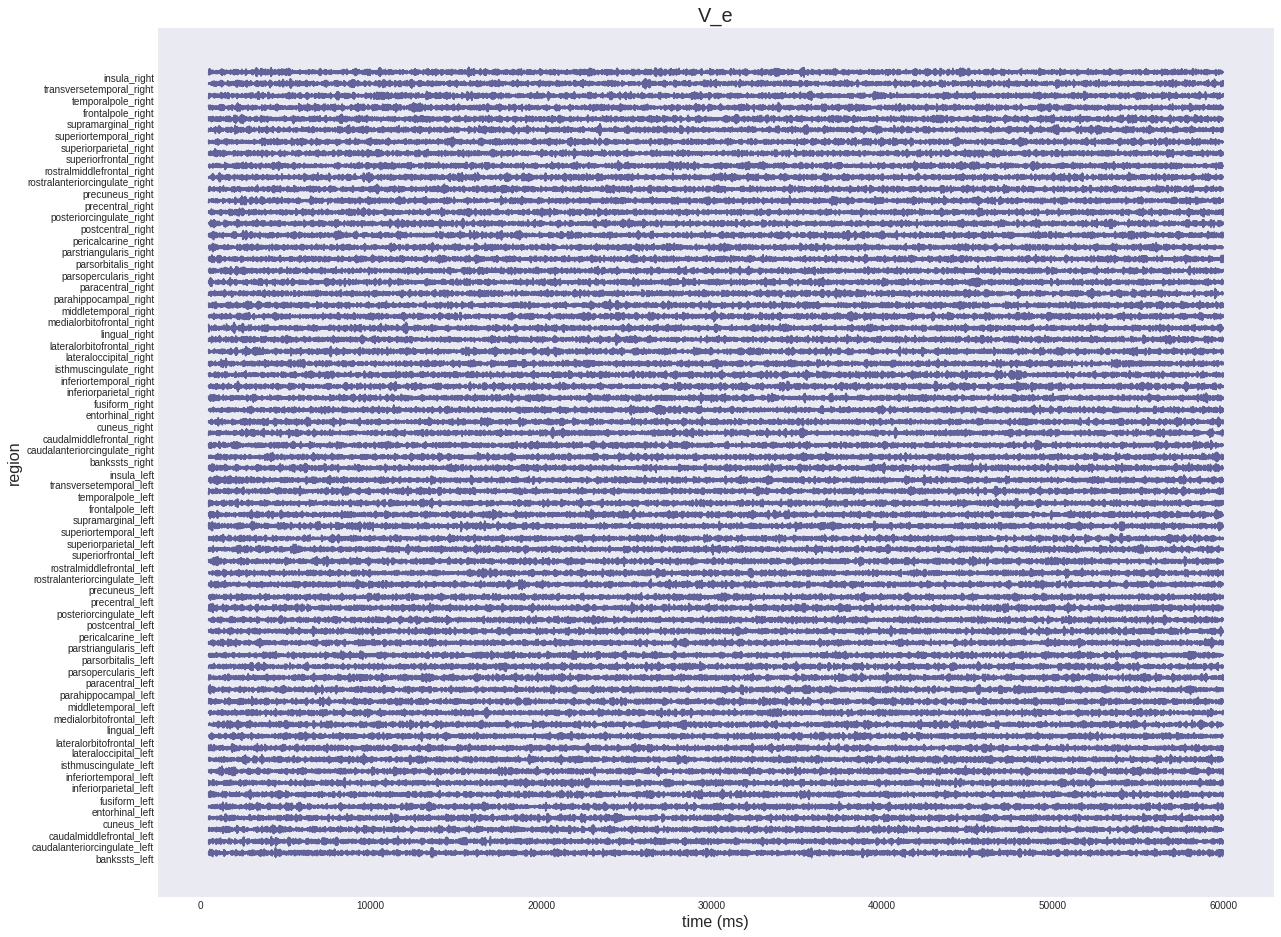

In [33]:
nrows = len(sim.connectivity.region_labels)
trtime = 100
plt.figure(figsize=(20,16))
    # Normalization
tavg_data_n = tavg_data_all[:, 1, :, 0][trtime:, :]
for r in range(nrows):
    tavg_data_n[:,r] -= np.min(tavg_data_n[:, r])
tavg_data_n /= np.max(tavg_data_n)
     # Plotting
plt.plot(tavg_time[trtime:], tavg_data_n[:,:nrows] + np.r_[:nrows], alpha=0.8, color='#414186')
plt.xlabel('time (ms)', fontsize=16)
plt.yticks(np.arange(0,nrows), sim.connectivity.region_labels[:nrows])
plt.ylabel('region', fontsize=16)
plt.title(sim.model.state_variables[1], fontsize=20)

In [79]:
tvb.analyzers?

Object `tvb.analyzers` not found.


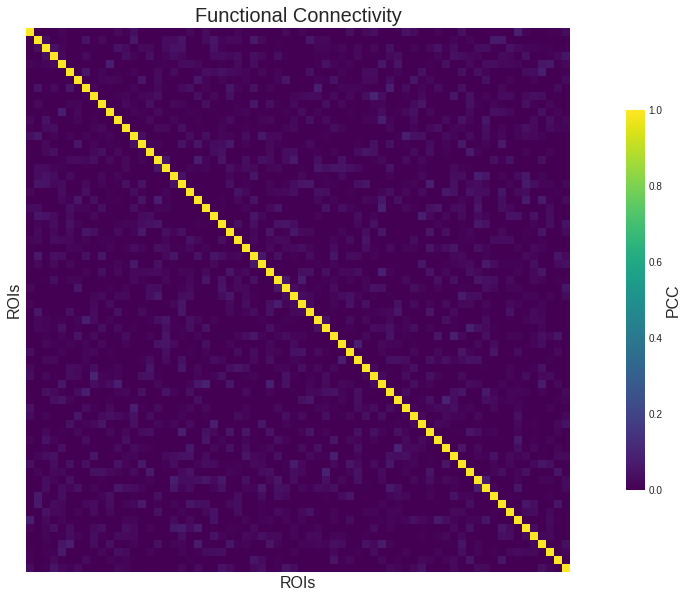

In [67]:
tavg_data_n = tavg_data_all[:, 0, :, 0][100:, :]
for r in range(nrows):
    tavg_data_n[:,r] -= np.min(tavg_data_n[:, r])
tavg_data_n /= np.max(tavg_data_n)
simFC = np.corrcoef(tavg_data_n[:,:].T)

plt.figure(figsize=(20,10))
plt.imshow(simFC,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('Functional Connectivity', fontsize = 20)
plt.xlabel('ROIs', fontsize=16); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)

In [58]:
simSC = sim.connectivity.weights
FCtriu = np.triu(simFC, 1)
SCtriu = np.triu(simSC, 1)

tavg_pcc = np.corrcoef(SCtriu.ravel(), FCtriu.ravel())[0, 1]
print('pcc = {}'.format(round(tavg_pcc,2)))

pcc = -0.06


***
Let's now visualize our BOLD data.
***

Text(0.5, 1.0, 'V_e')

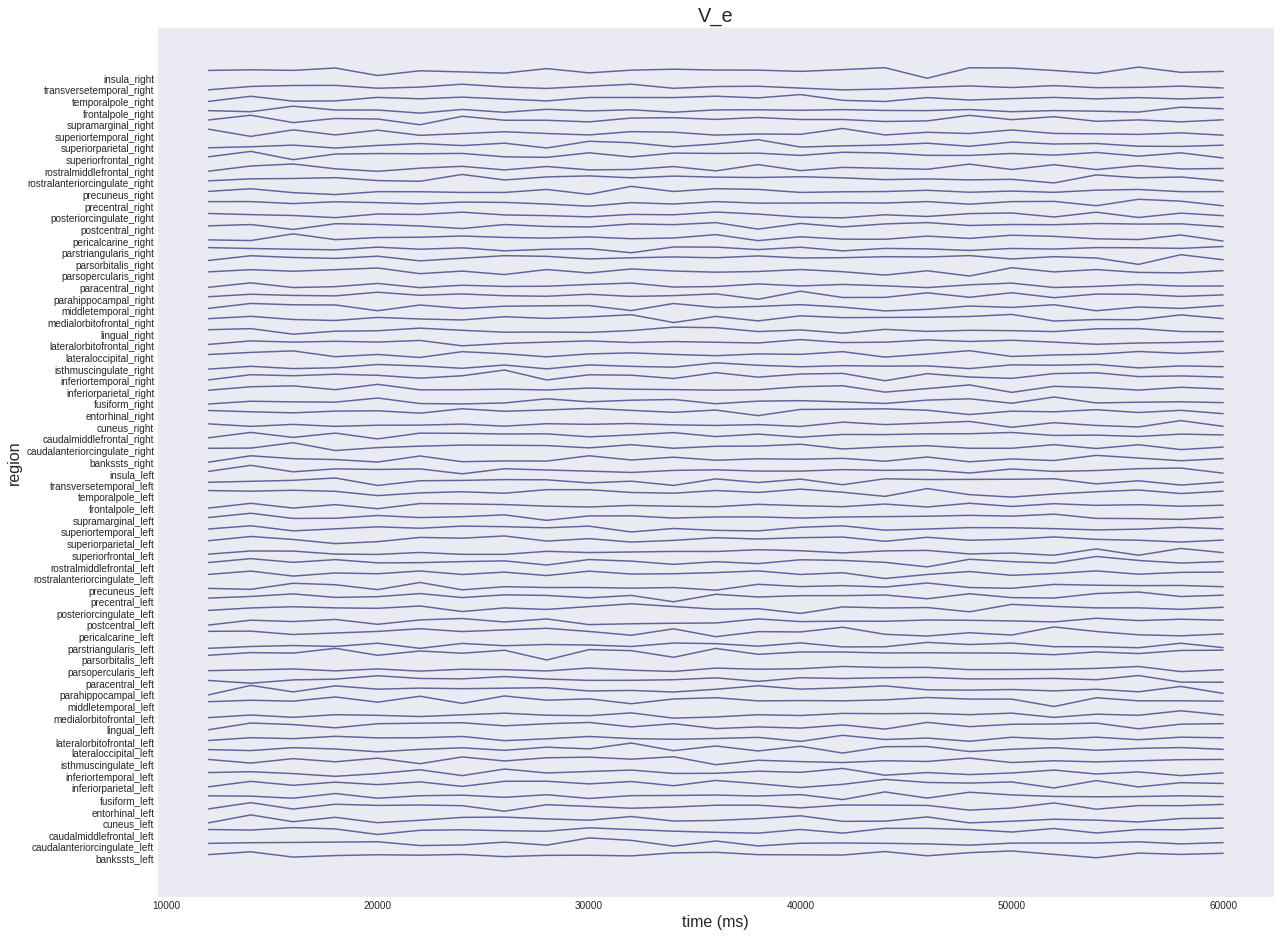

In [34]:
nrows = len(sim.connectivity.region_labels)
trtime = 5
    # Normalization
bold_data_n = bold_data_all[:, 1, :, 0][trtime:, :]
for r in range(nrows):
    bold_data_n[:,r] -= np.min(bold_data_n[:, r])
bold_data_n /= np.max(bold_data_n)
    # Plotting
plt.figure(figsize=(20,16))
plt.plot(bold_time[trtime:], bold_data_n[:,:nrows] + np.r_[:nrows], alpha=0.8, color='#414186')
plt.xlabel('time (ms)', fontsize=16); plt.ylabel('region', fontsize=16)
plt.yticks(np.arange(0,nrows), sim.connectivity.region_labels[:nrows])
plt.title(sim.model.state_variables[1], fontsize=20)

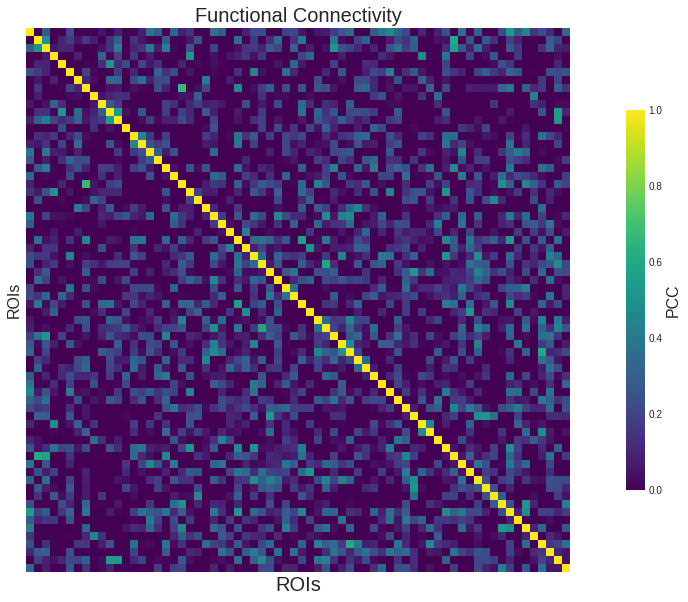

In [66]:
trtime = 5
    # Normalization
bold_data_n = bold_data_all[:, 0, :, 0][trtime:, :]
for r in range(nrows):
    bold_data_n[:,r] -= np.min(bold_data_n[:, r])
bold_data_n /= np.max(bold_data_n)
    # Computing FC
simFC = np.corrcoef(bold_data_n[:,:].T)
    # Plotting
plt.figure(figsize=(20,10))
plt.imshow(simFC,interpolation = 'nearest', cmap = 'viridis', vmin=0, vmax=1)
plt.title('Functional Connectivity', fontsize = 20)
plt.xlabel('ROIs', fontsize=20); plt.ylabel('ROIs', fontsize = 16)
plt.xticks([], fontsize = 16); plt.yticks([], fontsize = 16)
cb = plt.colorbar(shrink = 0.7)
cb.set_label('PCC', fontsize = 16)